# Linear Projection

In [1]:
from pathlib import Path
import hashlib
import pickle
import numpy as np
from sklearn.neighbors import NearestNeighbors

## Data dependencies

```
tencent-compound-c4.pkl 0eb1e3
```

In [2]:
c4_path = Path("../data/tencent-compound-c4.pkl")
c2_path = Path("../data/tencent-compound-c2.pkl")
for path_x in (c4_path,c2_path):
    h = hashlib.sha1()
    h.update(path_x.read_bytes())
    print("{} {}".format(path_x.name, h.digest().hex()[:6]))

tencent-compound-c4.pkl 0eb1e3
tencent-compound-c2.pkl 03d4cd


In [3]:
c4 = pickle.loads(c4_path.read_bytes())
c2 = pickle.loads(c2_path.read_bytes())
c4_train = c4["train"]
c4_val = c4["val"]
c4_test = c4["test"]
c2_train = c2["train"]
c2_val = c2["val"]
c2_test = c2["test"]
print("c4_comps train/val/test: ", c4_train["comps"].shape, c4_val["comps"].shape, c4_test["comps"].shape)
print("c2_comps train/val/test: ", c2_train["comps"].shape, c2_val["comps"].shape, c2_test["comps"].shape)

c4_comps train/val/test:  (154305, 200) (19288, 200) (19289, 200)
c2_comps train/val/test:  (22318, 200) (2790, 200) (2790, 200)


In [4]:
list(c4_train.keys())

['comps', 'consts', 'comps_text', 'c1_text', 'c2_text']

## Estimate Projection

In [5]:
def compute_projection(A, B):
    """
    AX = B
    return the estimated X
    """
    AtA_inv = np.linalg.inv(np.dot(A.transpose(), A))
    X = np.dot(np.dot(AtA_inv, A.transpose()), B)
    return X

def predict(A, X):
    return np.dot(A, X)

In [6]:
train_c4_X = compute_projection(c4_train["consts"], c4_train["comps"])
nbrs = NearestNeighbors(n_neighbors=15, metric="cosine").fit(c4_test["comps"])
test_c4_preds = predict(c4_test["consts"], train_c4_X)
_, pred_c4_test_idxs = nbrs.kneighbors(test_c4_preds)

In [7]:
train_c2_X = compute_projection(c2_train["consts"], c2_train["comps"])
nbrs = NearestNeighbors(n_neighbors=15, metric="cosine").fit(c2_test["comps"])
test_c2_preds = predict(c2_test["consts"], train_c2_X)
_, pred_c2_test_idxs = nbrs.kneighbors(test_c2_preds)

In [8]:
def compute_topk(pred_idxs):
    topks = []
    for k in range(15):
        correct_mat = pred_idxs[:,:k+1]==np.arange(pred_idxs.shape[0])[:, np.newaxis]
        acc = np.sum(np.any(correct_mat, axis=1))/correct_mat.shape[0]
        topks.append(acc)
    return topks

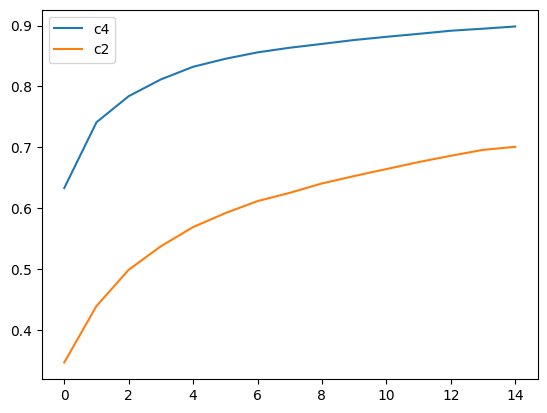

In [9]:
import matplotlib.pyplot as plt
plt.plot(compute_topk(pred_c4_test_idxs), label='c4')
plt.plot(compute_topk(pred_c2_test_idxs), label='c2')
plt.legend()